In [1]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [3]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'gmm_exp' in c['name'] 
        and c['config']['dataset']['n_sets'] == 10000
        and c['config']['experiment']['latent_dim'] == 32
        and c['config']['experiment']['hidden_dim'] == 128
        and c['config']['dataset']['prior_mu'] == [0, 5]
        and c['config']['dataset']['set_size'] == 500
]

In [8]:
import hydra
# load + prep dataset
def prepare_dataset_and_mixer(cfg, set_size=None, n_sets=None):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    if set_size is not None:
        cfg['dataset']['set_size'] = set_size
    if n_sets is not None:
        cfg['dataset']['n_sets'] = n_sets
    dataset = hydra.utils.instantiate(cfg['dataset'])
    mixer = hydra.utils.instantiate(cfg['mixer'])
    return dataset, mixer

from torch.utils.data import DataLoader
ds, mx = prepare_dataset_and_mixer(cfgs[0]['config'], set_size=1_000_000, n_sets=100)
dl = DataLoader(ds, batch_size=8, shuffle=False, collate_fn=mx.collate_fn)

dl_iter = iter(dl)
s1 = next(dl_iter)

# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

enc, gen = load_model(cfgs[0]['config'], cfgs[0]['dir'], device)


In [21]:
dl_iter = iter(dl)
s1 = next(dl_iter)
s2 = next(dl_iter)

In [36]:
s2.keys()

dict_keys(['samples', 'mean', 'cov', 'weights'])

In [24]:
ds[0]

{'samples': tensor([[2.2812, 4.5631],
         [1.7611, 4.7738],
         [2.0546, 4.5562],
         ...,
         [2.2892, 4.4214],
         [1.8584, 4.9121],
         [1.7633, 5.1625]]),
 'mean': tensor([1.8727, 4.7536]),
 'cov': tensor([[0.0474, 0.0108],
         [0.0108, 0.0744]])}

In [6]:
i, j = 0, 1
s1 = ds.sample(
    ds.weights[i][None, :], ds.mu[i][None, :], ds.cov[i][None, :, :], 1, 1_000_000, (2,)
).squeeze()
s2 = ds.sample(
    ds.weights[j][None, :], ds.mu[j][None, :], ds.cov[j][None, :, :], 1, 1_000_000, (2,)
).squeeze()

AttributeError: 'MultivariateNormalDistributionDataset' object has no attribute 'weights'

In [6]:
import numpy as np
import torch
lat = enc(torch.from_numpy(np.concatenate([s1[None, :, :], s2[None, :, :]], axis=0)).float().to(device))
# resample = gen.sample(lat, 1_000_000, return_trajectory=False)
# linearly interpolate between the two points
lat_interp = lat[0] + (lat[1] - lat[0]) * torch.linspace(0, 1, 10)[:, None].to(device)
resample = gen.sample(lat_interp, 1_000_000, return_trajectory=False)


Text(0.5, 1.0, 'Resampled Distribution')

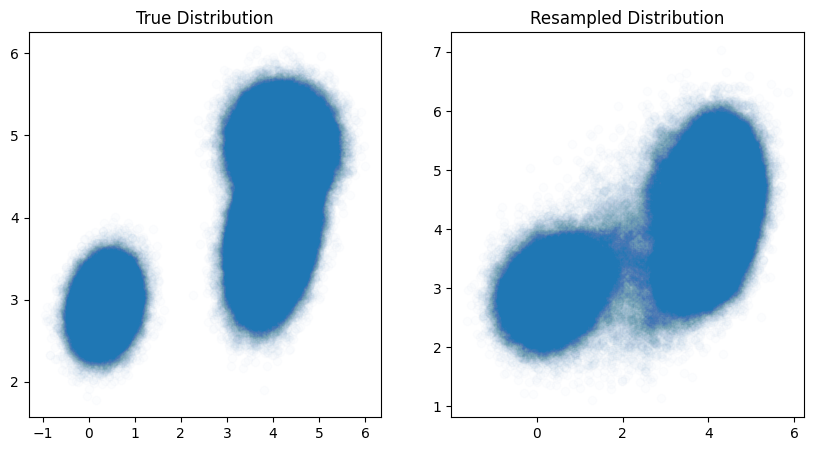

In [7]:
from matplotlib import pyplot as plt

# create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(s1[:, 0], s1[:, 1], label='s1', alpha=0.01)
axs[1].scatter(resample[0, :, 0].cpu().numpy(), resample[0, :, 1].cpu().numpy(), label='resample', alpha=0.01)
axs[0].set_title('True Distribution')
axs[1].set_title('Resampled Distribution')



In [9]:
from gmm_utils import fit_gmm_batch

init_means = np.repeat(ds.mu[0][None, :, :], 10, axis=0)
init_covs = np.repeat(ds.cov[0][None, :, :, :], 10, axis=0)
init_weights = np.repeat(ds.weights[0][None, :], 10, axis=0)
resample_means, resample_covs, resample_weights = fit_gmm_batch(resample.cpu().numpy(), init_means, init_covs, init_weights)



Fit GMM for mixture 0


/home/njwfish/miniconda3/envs/cell-types/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fit GMM for mixture 1


/home/njwfish/miniconda3/envs/cell-types/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fit GMM for mixture 2


/home/njwfish/miniconda3/envs/cell-types/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fit GMM for mixture 3


/home/njwfish/miniconda3/envs/cell-types/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fit GMM for mixture 4


/home/njwfish/miniconda3/envs/cell-types/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fit GMM for mixture 5
Fit GMM for mixture 6


/home/njwfish/miniconda3/envs/cell-types/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fit GMM for mixture 7


/home/njwfish/miniconda3/envs/cell-types/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fit GMM for mixture 8


/home/njwfish/miniconda3/envs/cell-types/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Fit GMM for mixture 9


In [11]:
import numpy as np
import matplotlib.pylab as pl
from matplotlib import colormaps as cm
import ot
import ot.plot
from ot.utils import proj_SDP, proj_simplex
from ot.gmm import gmm_ot_loss
import torch
from torch.optim import SGD
from matplotlib.patches import Ellipse

def generate_ot_trajectory(
        mean1, cov1, weights1, mean2, cov2, weights2, 
        n_steps=10, lr=1e-2, n_gd_its=100
    ):
    """
    Generate the correct Optimal Transport trajectory between two Gaussian distributions.
    
    Parameters:
    -----------
    mean1 : array-like
        Initial mean (2D vector)
    cov1 : array-like
        Initial covariance matrix (2x2)
    mean2 : array-like
        Final mean (2D vector)
    cov2 : array-like
        Final covariance matrix (2x2)
    n_steps : int
        Number of interpolation steps
        
    Returns:
    --------
    means : array-like
        List of interpolated means
    covs : array-like
        List of interpolated covariance matrices
    """
    m_s = torch.tensor(mean1, requires_grad=True)
    C_s = torch.tensor(cov1, requires_grad=True)
    w_s = torch.tensor(weights1, requires_grad=True)
    m_t = torch.tensor(mean2, requires_grad=True)
    C_t = torch.tensor(cov2, requires_grad=True)
    w_t = torch.tensor(weights2, requires_grad=True)

    opt = SGD(
        [
            {"params": m_s, "lr": lr},
            {"params": C_s, "lr": lr},
            {"params": w_s, "lr": lr},
        ]
    )

    means_list = [m_s.data.numpy().copy()]
    covs_list = [C_s.data.numpy().copy()]
    weights_list = [torch.softmax(w_s, 0).data.numpy().copy()]
    loss_list = []

    for _ in range(n_gd_its):
        opt.zero_grad()
        loss = gmm_ot_loss(m_s, m_t, C_s, C_t, torch.softmax(w_s, 0), w_t)
        loss.backward()
        opt.step()
        with torch.no_grad():
            C_s.data = proj_SDP(C_s.data, vmin=1e-6)
            means_list.append(m_s.data.numpy().copy())
            covs_list.append(C_s.data.numpy().copy())
            weights_list.append(torch.softmax(w_s, 0).data.numpy().copy())
            loss_list.append(loss.item())

    ot_means, ot_covs, ot_weights = np.array(means_list), np.array(covs_list), np.array(weights_list)
    # get 10 steps evenly spaced from the trajectory of 101 points using indices
    indices = np.linspace(0, 100, n_steps).astype(int)
    ot_means = ot_means[indices]
    ot_covs = ot_covs[indices]
    ot_weights = ot_weights[indices]
    return ot_means, ot_covs, ot_weights

ot_means, ot_covs, ot_weights = generate_ot_trajectory(ds.mu[0], ds.cov[0], ds.weights[0], ds.mu[1], ds.cov[1], ds.weights[1], 10)

(<Figure size 1500x600 with 3 Axes>,
 (<Axes: xlabel='x', ylabel='y'>,
  <Axes: title={'center': 'Weight Simplex Trajectory'}>))

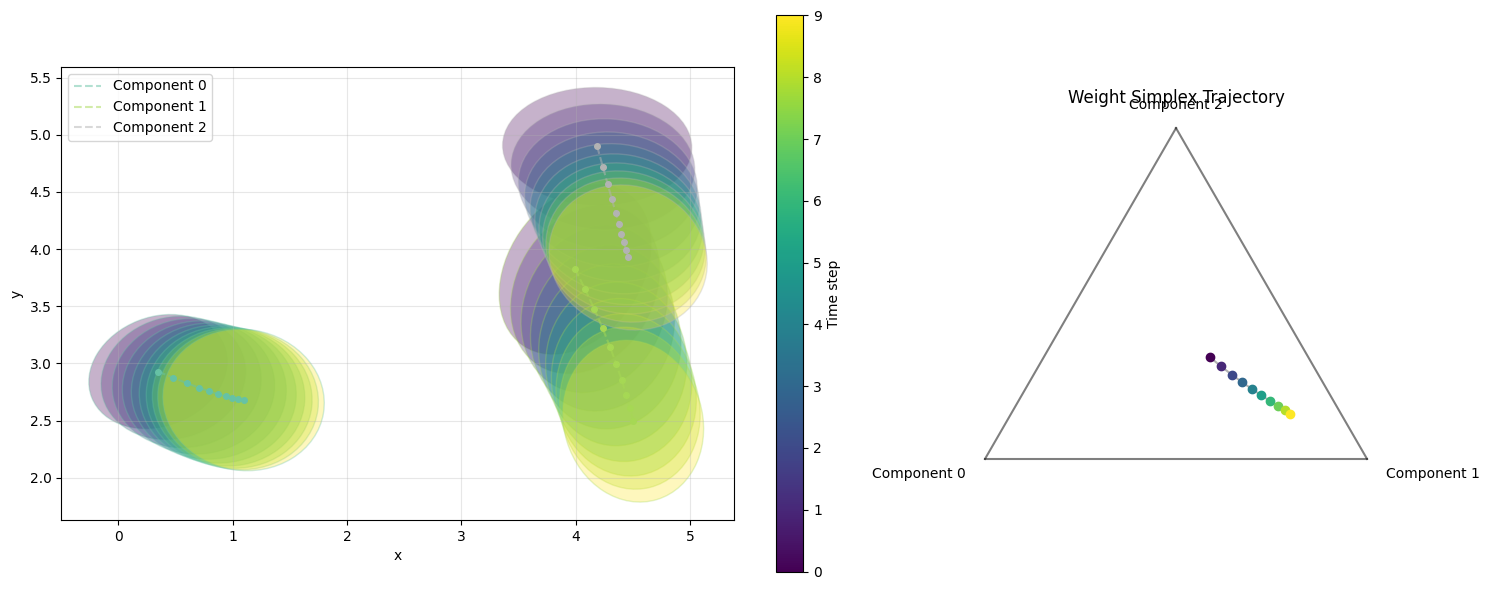

In [12]:
from gmm_utils import plot_gmm_trajectory

plot_gmm_trajectory(ot_means, ot_covs, ot_weights)

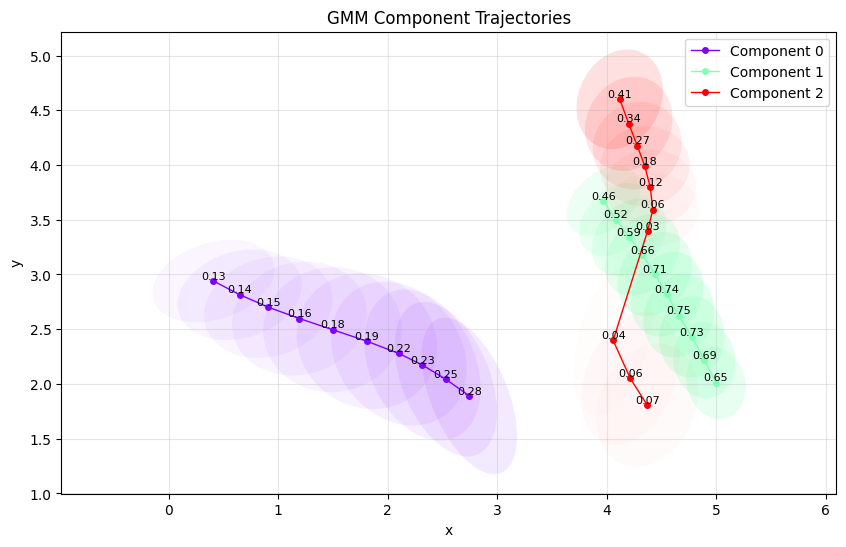

In [10]:
from gmm_utils import plot_gmm_trajectory

plot_gmm_trajectory(resample_means, resample_covs, resample_weights)